In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [3]:
# Function required for Newton's system

def f(x ,y, m):
    return -np.exp(m) * x**2 + np.sin(y)

def g(x ,y, m1):
    return np.exp(-((x-1.)**2)/2.) - (y**3-y+1.)

#First derivative

def fx(x ,y, m):
    return -np.exp(m) * x * 2 

def fy(x ,y, m):
    return np.cos(y)

def fm(x ,y, m):
    return -np.exp(m) * x**2

def gx(x ,y, m):
    return (-(x-1.))*np.exp(-((x-1.)**2)/2.)

def gy(x ,y, m):
    return 1.-3.*y**2

def gm(x ,y, m):
    return 0

# Second derivative

def fxx(x ,y, m):
    return -2.*np.exp(m)

def fxy(x ,y, m):
    return 0 

def fxm(x ,y, m):
    return -2.*np.exp(m)*x

def fyx(x ,y, m):
    return 0

def fyy(x ,y, m):
    return -np.sin(y)

def fym(x ,y, m):
    return 0 

def fmx(x ,y, m):
    return -2.*np.exp(m)*x

def fmy(x ,y, m):
    return 0

def fmm(x ,y, m):
    return -np.exp(m)*x**2

def gxx(x ,y, m):
    return (((x-1.)**2)-1.)*np.exp(-((x-1.)**2)/2.)

def gxy(x ,y, m):
    return 0 

def gxm(x ,y, m):
    return 0

def gyx(x ,y, m):
    return 0

def gyy(x ,y, m):
    return -6.*y

def gym(x ,y, m):
    return 0

def gmx(x ,y, m):
    return 0

def gmy(x ,y, m):
    return 0

def gmm(x ,y, m):
    return 0

# Function required for the adjoint based newton system
def w(x,y,m,la,mu):
    return la*fmm(x,y,m) + mu*gmm(x,y,m)

def Fnew(x,y,m,la,mu,xh,yh,lah,muh):
    return (lah * fm(x,y,m) + muh * gm(x,y,m) + la * (fmx(x,y,m) * xh + fmy(x,y,m) * yh) 
           + mu * (gmx(x,y,m) * xh + gmy(x,y,m) * yh))

# Function required for state Simultaneous Approach

def F(x0, y0, x1, y1, m):
    return x1 - x0 - .5 * dt *( f(x1, y1, m) + f(x0, y0, m) )

def Fx(x, y, m):
    return 1 - .5 * dt * fx(x, y, m)

def Fy(x, y, m):
    return - .5 * dt * fy(x, y, m)

def detJ(x, y, m):
    return Fx(x, y, m) * gy(x, y, m) - Fy(x, y, m)* gx(x, y, m)


In [4]:
# Forward solver by Simultaneous Approach
def Forward_solve2(x,y,m):

    for t in range(len(x) - 1):
        xst = x[t]
        yst = y[t]

        iter = 0
        while iter < max_iter:
            dJ = 1 / detJ(xst, yst, m)
            sx = -dJ * (F(x[t], y[t], xst, yst, m) * gy(xst, yst, m) - g(xst, yst, m) * Fy(xst, yst, m))
            sy = -dJ * (g(xst, yst, m) * Fx(xst, yst, m) - F(x[t],y[t],xst, yst, m) * gx(xst, yst, m))

            xst += sx
            yst += sy        

            if np.sqrt(sx**2 + sy**2) < epislon_DAE:
                break

            iter += 1

        x[t+1] = xst
        y[t+1] = yst

# Forward solver by Nested Approach
def Forward_solve(x,y,m):
    
    iter = 0
    yst = y[0]
    while iter < max_iter:
        s = - g(x[0], yst,m)/ gy(x[0], yst,m)
        yst += s
        if abs(s) < epislon_DAE:
            y[0] = yst
            break
        iter += 1
    
    
    for i in range(len(x)):

        iter = 0
        yst = y[i]
        while iter < max_iter:
            s = - g(x[i], yst,m)/ gy(x[i], yst,m)
            yst += s
            if abs(s) < epislon_DAE:
                y[i] = yst
                break
            iter += 1


        if i != len(x)-1:
            k1 = f(x[i], y[i],m)
            k2 = f(x[i]+ .5*dt*k1, y[i],m)
            k3 = f(x[i]+ .5*dt*k2, y[i],m)
            k4 = f(x[i]+    dt*k3, y[i],m)
            x[i+1] = x[i] + (dt/6)*(k1+2*k2+2*k3+k4)  
            
    
# Adjoint solver
def adjoint_solver(x,y,m,la,mu):
    la[-1] = 0
    mu[-1] = 0
    # Backwards Euler
    for t in range(len(x) - 1,0,-1):
        la[t-1] = (1 + dt * fx(x[t], y[t],m) ) * la[t] + dt * ( (x[t] - d[t]) 
                                                                   + mu[t]* gx(x[t],y[t],m) ) 
        mu[t-1] = - la[t-1] * (fy(x[t-1],y[t-1],m) / gy(x[t-1],y[t-1],m))


# Gradient evualation
def Grad_eval(x,y,m):
    grad = 0.
    for t in range(len(x)):
        grad += la[t] * fm(x[t],y[t],m) + mu[t] * gm(x[t],y[t],m)

    grad *= dt

    gnorm = np.abs(grad)

    return gnorm, grad

# cost function
def cost(x,d):
    cost = 0
    for t in range(len(x)):
        cost += (x[t] - d[t]) * (x[t] - d[t])

    cost *= dt/2
    return cost

# Incremental State solver
def Inc_state(x,y,m,xh,yh,mh):
    for t in range(len(x) - 1):

        temp_sum = 1 - dt*fx(x[t+1],y[t+1],m) + dt * (gx(x[t+1],y[t+1],m) * fy(x[t+1],y[t+1],m) 
                                                      / gy(x[t+1],y[t+1],m))
        
        xh[t+1] = (1 / temp_sum) * (xh[t] + dt* mh *(fm(x[t+1],y[t+1],m) 
                                                    - (gm(x[t+1],y[t+1],m) * fy(x[t+1],y[t+1],m)
                                                       / gy(x[t+1],y[t+1],m))) )
        
        yh[t+1] = - (1/gy(x[t+1],y[t+1],m)) * (xh[t+1]  * gx(x[t+1],y[t+1],m) 
                                                   + mh * gm(x[t+1],y[t+1],m))

# Incremental Adjoint solver
def Inc_Adj(x,y,m,la,mu,xh,yh,mh,lah,muh):
    lah[-1] = 0
    muh[-1] = 0
    for t in range(len(x) - 1,0,-1):
        lah[t-1] = (1 + dt * fx(x[t],y[t],m)) * lah[t] + dt * ( xh[t] + muh[t] * gx(x[t],y[t],m) 
                                   + la[t] * (xh[t] * fxx(x[t],y[t],m) + yh[t] * fxy(x[t],y[t],m) 
                                                + mh * fxm(x[t],y[t],m) ) 
                                   + mu[t] * (xh[t] * gxx(x[t],y[t],m) + yh[t] * gxy(x[t],y[t],m) 
                                                + mh * gxm(x[t],y[t],m)) ) 
        
        muh[t-1] = - (1/ gy(x[t-1],y[t-1],m))  * (lah[t-1] * fy(x[t-1],y[t-1],m)
                                   + la[t-1] * (xh[t-1] * fyx(x[t-1],y[t-1],m) + yh[t-1] * fyy(x[t-1],y[t-1],m) 
                                              + mh * fym(x[t-1],y[t-1],m) )  
                                   + mu[t-1] * (xh[t-1] * gyx(x[t-1],y[t-1],m) + yh[t-1] * gyy(x[t-1],y[t-1],m) 
                                              + mh * gym(x[t-1],y[t-1],m) ) )

# Update comonent for newton updating step
def Newton_update(x ,y, m, la, mu, xh, yh, lah, muh):
    W = 0
    Fn = 0    
    for t in range(len(x)):
        W  += w(x[t] ,y[t], m, la[t], mu[t])
        Fn += Fnew(x[t],y[t],m,la[t],mu[t],xh[t],yh[t],lah[t],muh[t])
        
    W  *= dt 
    Fn *= dt
    
    return W, Fn

def Newton_Linear_solve(x ,y, m, la, mu, xh, yh, lah, muh, grad):
    W, Fn = Newton_update(x ,y, m, la, mu, xh, yh, lah, muh)
    
    return -(Fn + grad)/W

# Create synthetic observation
def Observation(x):
    noise_lvl = 0.02

    noise_vec = noise_lvl * (np.random.random_sample(n) - 0.5) * 2 

    d = noise_vec + x
    return d

In [5]:
def Initial_system(n):
    # forward system
    x = np.zeros(n)
    y = np.zeros(n)
    x[0] = 1
    #     y[0] = 0

    # adjoint system
    la = np.zeros(n)
    mu = np.zeros(n)
    la[-1] = 0
    mu[-1] = 0

    # Incremental forward system
    xh = np.zeros(n)
    yh = np.zeros(n)
    xh[0] = 0
    yh[0] = 0

    # Incremental adjoint system
    lah = np.zeros(n)
    muh = np.zeros(n)
    lah[-1] = 0
    muh[-1] = 0
    
    return x,y,la,mu,xh,yh,lah,muh

In [6]:
# parameters
t_init         = 0.
t_final        = 1.
t_obs          = 1.
dt             = .01

n = round ((t_final - t_init) /dt)
n_obs = round ((t_obs - t_init) /dt)
time = np.linspace(t_init, t_final, n)
time_obs = np.linspace(t_init, t_obs, n_obs)

noise = .02

# Initialize system
x,y,la,mu,xh,yh,lah,muh = Initial_system(n)

# DAE Newton system parameter
epislon_DAE = 1e-6

# Newton system parameter
max_iter = 100
tol = 1e-9

# data
d = np.zeros(n)

# True parameter
mtrue = 0.693

# Create synthetic observation
Forward_solve(x,y,mtrue)
d = Observation(x)

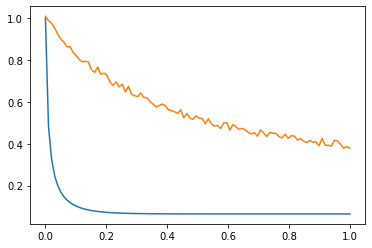

1 0.12607092759250269 0.028159056542086166 0.027756481712526253 1.944592920288947


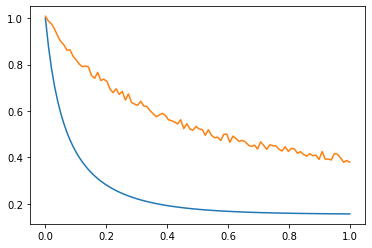

2 0.05683728359897978 0.044695032684200636 0.08924995212925291 0.052272206980600866


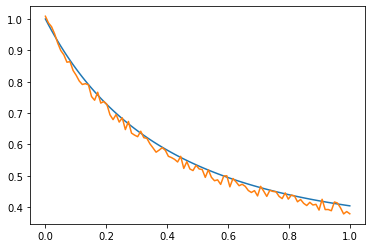

3 0.00013807514860631802 0.002532107296101942 6.411567358972688e-06 0.049740099684498884
Termiination reason: Norm of the gradient less than tolerance


In [7]:
# initial guess
m = 4.609
Max_new_iter = 10
new_iter = 0
arm_it_max = 10
mh = 0.01
err = []
err.append(np.abs(m - mtrue))

c = 10**(-4)
line_search = True
suff_dec = False
while (new_iter < Max_new_iter):
    Forward_solve(x,y,m)
    adjoint_solver(x,y,m,la,mu)
    Jk = cost(x, d)
    gnorm, grad = Grad_eval(x,y,m)
    
    plt.plot(time,x)
    plt.plot(time,d)
    plt.show()
    
    Inc_state(x,y,m,xh, yh, mh)
    Inc_Adj(x,y,m,la,mu,xh,yh,mh,lah, muh)
    mh = Newton_Linear_solve(x ,y, m, la, mu, xh, yh, lah, muh, grad)
    
    #line search
    if line_search:
        if np.sign(mh*grad) > 0:
            alpha = 100.
            mh = -grad
        else:
            alpha = 1.
        
        arm_it = 0
        
        while (not suff_dec) and arm_it < arm_it_max:
            Forward_solve(x,y,m+alpha*mh)
            J = cost(x,d)
            if J < Jk + c*alpha*mh*grad:
                suff_dec = True
                m += alpha * mh
                
            else:
                alpha *= 0.5
                arm_it += 1
            
    
    m += mh
    
    new_iter += 1
    err.append(np.abs(m - mtrue))
    print(new_iter, Jk, abs(grad), abs(mh*grad), err[new_iter])
    
    if (abs(grad) < 1E-4 or abs(mh*grad) < 1E-4):
        print("Termiination reason: Norm of the gradient less than tolerance")
        break
    

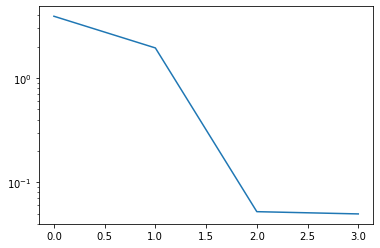

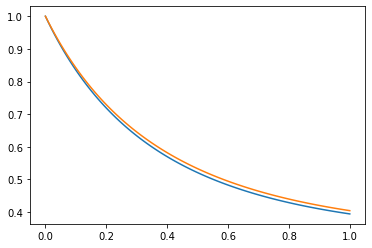

In [8]:
plt.semilogy(err)
plt.show()

xapprox = np.copy(x)
# Initialize system
xt,yt,_,_,_,_,_,_ = Initial_system(n)
Forward_solve(xt,yt,mtrue)
plt.plot(time, xt,label = "True")
plt.plot(time,xapprox, label = "Approx")
plt.show()